In [2]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from modules.asset import Asset


In [65]:
start_date = "2013-01-01"
end_date = "2017-01-01"
tick_type = "Close"

swiss_re = Asset(
    asset_name="SwissRe",
    tick_name="SREN.SW",
    time_period=(start_date, end_date),
    value_type=tick_type
)

swiss_re.compute_realized_volatility(window=10, store=True)

/Users/emiliomaddalena/Documents/github/volatility-forecasting/modules/asset.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.tick_name, start=self.start_date, end=self.end_date)
[*********************100%***********************]  1 of 1 completed


Date
2013-01-04         NaN
2013-01-07         NaN
2013-01-08         NaN
2013-01-09         NaN
2013-01-10         NaN
                ...   
2016-12-23    0.000057
2016-12-27    0.000037
2016-12-28    0.000040
2016-12-29    0.000040
2016-12-30    0.000040
Name: SREN.SW, Length: 1002, dtype: float64

In [66]:
def plot_series(asset: Asset, series_types: List[str] | str, fig_size: tuple = (8, 6), labels: List[str] | None = None) -> None:
    """Plot the time series data for a list of assets, individual plots."""
    color_sequence = ['k', 'r', 'b', 'g', 'm', 'c', 'y']
    if isinstance(series_types, str):
        series_types = [series_types]
    if labels is None:
        labels = series_types
    plt.figure(figsize=fig_size)
    for i, series_type in enumerate(series_types):
        series = asset.__getattribute__(series_type)
        plt.plot(series.index, series, color=color_sequence[i], label=labels[i])
        years = pd.date_range(start=series.index[0], end=series.index[-1], freq="YS").year
        years = np.unique(np.concatenate(([series.index[0].year], years, [series.index[-1].year + 1])))
        ticks = [pd.Timestamp(year=year, month=1, day=1) for year in years]
    plt.title(f"{asset.asset_name} ({asset.tick_name})")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.xlim([series.index[0], series.index[-1]])
    plt.xticks(ticks=ticks, labels=[str(year) for year in years], rotation=45)
    plt.legend()
    plt.grid()

def plot_autocorr(asset: Asset, fig_size: tuple = (8, 6)) -> None:
    vol = asset.pointwise_volatility
    autocorr = [vol.autocorr(lag) for lag in range(1, 30)]
    plt.figure(figsize=fig_size)
    plt.bar(range(1, 30), autocorr, color='k', zorder=10)
    plt.title(f"{asset.asset_name} ({asset.tick_name[1:]})")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid()

def plot_histogram(asset: Asset, value_type: str, nbins: int = 30,xlims: List[float] = None) -> None:
    plt.figure(figsize=(8, 6))
    series = asset.__getattribute__(value_type)
    sns.histplot(series.dropna(), color='k', alpha=1., bins=nbins,stat="density", zorder=10, edgecolor='white', linewidth=2.5)
    sns.kdeplot(series.dropna(), bw_adjust=1, color='r', alpha=1., zorder=10, linewidth=2.)
    plt.title(f"{asset.asset_name} ({asset.tick_name[1:]}) Histogram")
    if xlims:
        plt.xlim(xlims)
    plt.xlabel("Value")
    plt.grid()

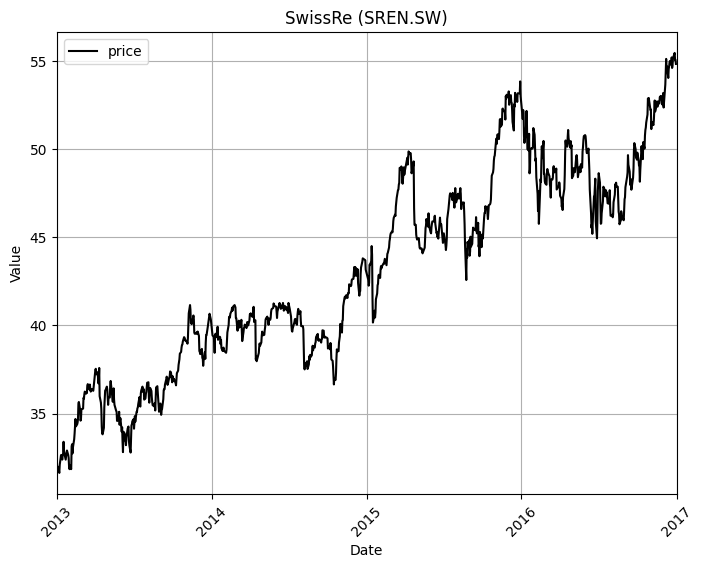

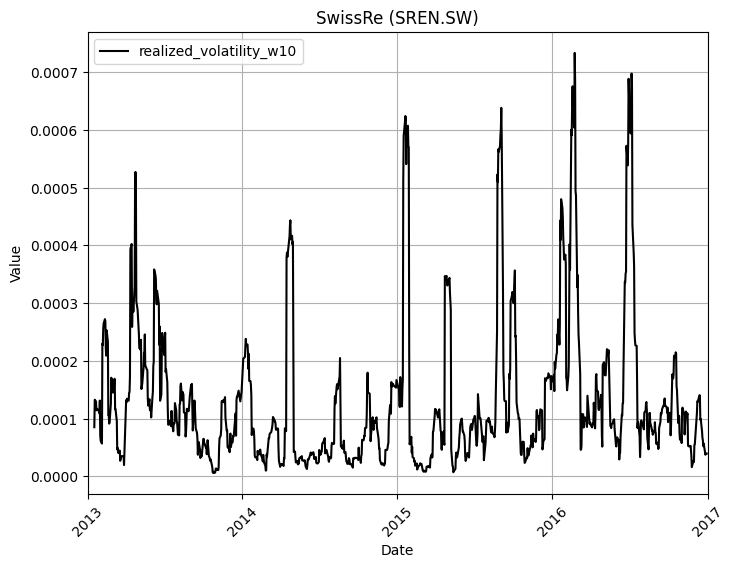

In [67]:
plot_series(swiss_re, "price", fig_size=(8, 6))
plot_series(swiss_re, "realized_volatility_w10", fig_size=(8, 6))

In [68]:
series = swiss_re.realized_volatility_w10
series

Date
2013-01-04         NaN
2013-01-07         NaN
2013-01-08         NaN
2013-01-09         NaN
2013-01-10         NaN
                ...   
2016-12-23    0.000057
2016-12-27    0.000037
2016-12-28    0.000040
2016-12-29    0.000040
2016-12-30    0.000040
Name: SREN.SW, Length: 1002, dtype: float64

In [69]:
# standardize the time series

series_mean = series.mean()
series_std = series.std()

def standardize(s: pd.Series) -> pd.Series:
    return (s - series_mean) / series_std
def destandardize(s: pd.Series) -> pd.Series:
    return s * series_std + series_mean

series = standardize(series)
series.describe()

count    9.930000e+02
mean     1.001772e-16
std      1.000000e+00
min     -9.432503e-01
25%     -6.358719e-01
50%     -2.941467e-01
75%      1.855830e-01
max      4.559227e+00
Name: SREN.SW, dtype: float64

In [70]:
# 1) Prepare supervised features: lags + cyclical day-of-week (sin/cos)
def build_features_from_series(s: pd.Series, n_lags: int = 20) -> pd.DataFrame:
    s = s.copy().sort_index()
    df = pd.DataFrame({"y": s})
    # Day-of-week cyclical encoding
    dow = df.index.dayofweek  # Monday=0 .. Sunday=6
    theta = 2 * np.pi * dow / 5.0
    df["dow_sin"] = np.sin(theta)
    df["dow_cos"] = np.cos(theta)
    # Lags
    for k in range(1, n_lags + 1):
        df[f"lag_{k}"] = df["y"].shift(k)
    # Drop rows with NaNs from lagging
    df = df.dropna()
    return df


# 2) Time-series train/test split (no shuffling)
def time_series_train_test_split(
    df: pd.DataFrame, feature_cols: list[str], target_col: str, test_size: float = 0.2
):
    split_idx = int(len(df) * (1 - test_size))
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    X_train, y_train = train[feature_cols], train[target_col]
    X_test, y_test = test[feature_cols], test[target_col]
    return X_train, y_train, X_test, y_test, split_idx

def recursive_forecast_test(model, df_sup: pd.DataFrame, feature_cols: list[str], split_idx: int, n_lags: int) -> pd.Series:
    idx_test = df_sup.index[split_idx:]
    # Seed with last n_lags actual y values from the end of train
    y_hist = df_sup["y"].iloc[split_idx - n_lags: split_idx].to_list()  # oldest->...->most recent
    preds = []
    for t, ts in enumerate(idx_test):
        row = {}
        # Time features from the known calendar
        if "dow_sin" in df_sup.columns:
            row["dow_sin"] = df_sup.loc[ts, "dow_sin"]
            row["dow_cos"] = df_sup.loc[ts, "dow_cos"]
        # Lag features built from rolling history (most recent = lag_1)
        for k in range(1, n_lags + 1):
            row[f"lag_{k}"] = y_hist[-k]
        X_row = pd.DataFrame([row], index=[ts])[feature_cols]
        yhat = float(model.predict(X_row).item())
        preds.append(yhat)
        # Update history with prediction and keep last n_lags
        y_hist.append(yhat)
        if len(y_hist) > n_lags:
            y_hist = y_hist[-n_lags:]
    return pd.Series(preds, index=idx_test, name="yhat_test_open_loop")

In [82]:
# 3) Build dataset
n_lags = 30
df_sup = build_features_from_series(series, n_lags=n_lags)
feature_cols = ["dow_sin", "dow_cos"] + [f"lag_{k}" for k in range(1, n_lags + 1)]
X_train, y_train, X_test, y_test, split_idx = time_series_train_test_split(df_sup, feature_cols, "y", test_size=0.2)

# 4) Optional: keep a small validation slice from the tail of training for early stopping
val_frac = 0.1
val_idx = int(len(X_train) * (1 - val_frac))
X_tr, y_tr = X_train.iloc[:val_idx], y_train.iloc[:val_idx]
X_val, y_val = X_train.iloc[val_idx:], y_train.iloc[val_idx:]

In [106]:
def plot_series_list(series_list: List[pd.Series], colors: List[str], styles: List[str], labels: List[str] = None, fig_size: tuple = (8, 6)) -> None:
    """Plot multiple time series with custom colors and labels, capturing the longest time period."""
    if labels is None:
        labels = [f"Series {i+1}" for i in range(len(series_list))]
    plt.figure(figsize=fig_size)
    # Find global min/max dates
    min_date = min(s.index[0] for s in series_list)
    max_date = max(s.index[-1] for s in series_list)
    # Collect all years from all series
    all_years = set()
    for s in series_list:
        years = pd.date_range(start=s.index[0], end=s.index[-1], freq="YS").year
        all_years.update([s.index[0].year, *years, s.index[-1].year + 1])
    years = np.unique(list(all_years))
    ticks = [pd.Timestamp(year=year, month=1, day=1) for year in years]
    # Plot each series
    for s, color, style, label in zip(series_list, colors, styles, labels):
        plt.plot(s.index, s, color=color, linestyle=style, label=label, linewidth=3)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.xlim([min_date, max_date])
    plt.xticks(ticks=ticks, labels=[str(year) for year in years])#, rotation=45)
    plt.legend()
    plt.grid()

Train  RMSE: 0.247897  MAE: 0.055040
Test   one-step  RMSE: 0.416543  MAE: 0.228528
Test   open-loop RMSE: 0.887774  MAE: 0.585740


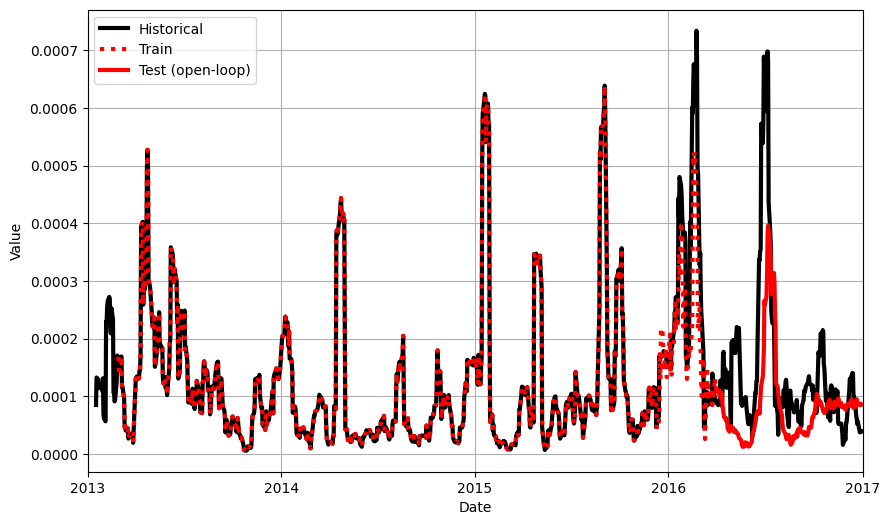

In [107]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,#200,
    learning_rate=0.1,
    max_depth=10,
    subsample=0.5,
    reg_lambda=0.5,#.5,
    random_state=123,#123,
)
model.fit(X_tr, y_tr)

# One-step-ahead (uses true past values, as before)
yhat_train = pd.Series(model.predict(X_train), index=y_train.index, name="yhat_train")
yhat_test_one_step = pd.Series(model.predict(X_test), index=y_test.index, name="yhat_test_one_step")
yhat_test_open_loop = recursive_forecast_test(model, df_sup, feature_cols, split_idx, n_lags)

# Metrics (on standardized scale)
rmse_train = root_mean_squared_error(y_train, yhat_train)
mae_train = mean_absolute_error(y_train, yhat_train)
rmse_test_os = root_mean_squared_error(y_test, yhat_test_one_step)
mae_test_os = mean_absolute_error(y_test, yhat_test_one_step)
rmse_test_ol = root_mean_squared_error(y_test, yhat_test_open_loop)
mae_test_ol = mean_absolute_error(y_test, yhat_test_open_loop)

print(f"Train  RMSE: {rmse_train:.6f}  MAE: {mae_train:.6f}")
print(f"Test   one-step  RMSE: {rmse_test_os:.6f}  MAE: {mae_test_os:.6f}")
print(f"Test   open-loop RMSE: {rmse_test_ol:.6f}  MAE: {mae_test_ol:.6f}")

plot_series_list([destandardize(s) for s in [series, yhat_train, yhat_test_open_loop]], colors=["black", "red", "red"], styles=["-", ":", "-"], labels=["Historical", "Train", "Test (open-loop)"], fig_size=(10, 6))

Train  RMSE: 0.117600  MAE: 0.024220
Test   one-step  RMSE: 0.612229  MAE: 0.358788
Test   open-loop RMSE: 1.490122  MAE: 1.007517


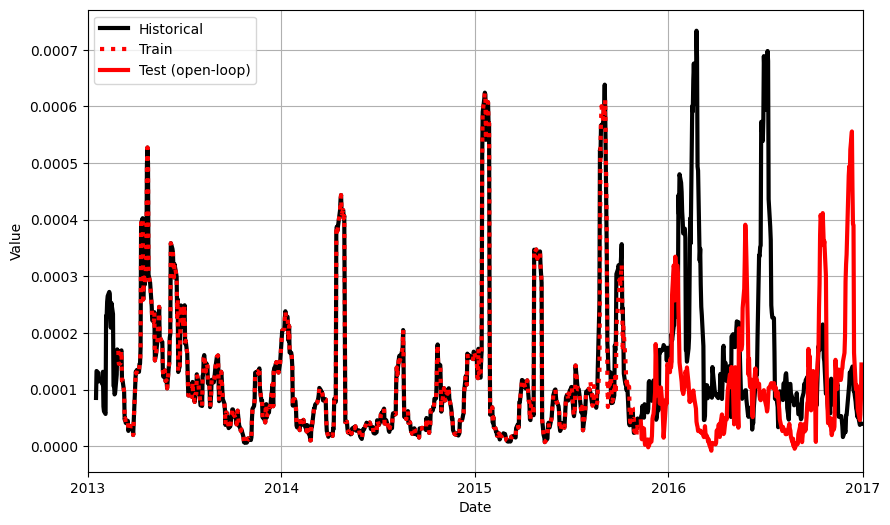

In [140]:
# 3) Build dataset
n_lags = 30
df_sup = build_features_from_series(series, n_lags=n_lags)
feature_cols = ["dow_sin", "dow_cos"] + [f"lag_{k}" for k in range(1, n_lags + 1)]
X_train, y_train, X_test, y_test, split_idx = time_series_train_test_split(df_sup, feature_cols, "y", test_size=0.3)

# 4) Optional: keep a small validation slice from the tail of training for early stopping
val_frac = 0.1
val_idx = int(len(X_train) * (1 - val_frac))
X_tr, y_tr = X_train.iloc[:val_idx], y_train.iloc[:val_idx]
X_val, y_val = X_train.iloc[val_idx:], y_train.iloc[val_idx:]

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,#200,
    learning_rate=.4,
    max_depth=10,
    subsample=0.5,
    reg_lambda=1.,#.5,
    random_state=1,#123,
)
model.fit(X_tr, y_tr)

# One-step-ahead (uses true past values, as before)
yhat_train = pd.Series(model.predict(X_train), index=y_train.index, name="yhat_train")
yhat_test_one_step = pd.Series(model.predict(X_test), index=y_test.index, name="yhat_test_one_step")
yhat_test_open_loop = recursive_forecast_test(model, df_sup, feature_cols, split_idx, n_lags)

# Metrics (on standardized scale)
rmse_train = root_mean_squared_error(y_train, yhat_train)
mae_train = mean_absolute_error(y_train, yhat_train)
rmse_test_os = root_mean_squared_error(y_test, yhat_test_one_step)
mae_test_os = mean_absolute_error(y_test, yhat_test_one_step)
rmse_test_ol = root_mean_squared_error(y_test, yhat_test_open_loop)
mae_test_ol = mean_absolute_error(y_test, yhat_test_open_loop)

print(f"Train  RMSE: {rmse_train:.6f}  MAE: {mae_train:.6f}")
print(f"Test   one-step  RMSE: {rmse_test_os:.6f}  MAE: {mae_test_os:.6f}")
print(f"Test   open-loop RMSE: {rmse_test_ol:.6f}  MAE: {mae_test_ol:.6f}")

plot_series_list([destandardize(s) for s in [series, yhat_train, yhat_test_open_loop]], colors=["black", "red", "red"], styles=["-", ":", "-"], labels=["Historical", "Train", "Test (open-loop)"], fig_size=(10, 6))

In [109]:
len(series)

1002